# Type transformations

Transforming individual geometries: 

- `MultiPoint` to `LineString`
- `MultiPoint` to `Polygon`
- `LineString` to `MultiPoint`
- `Polygon` to `MultiPoint`
- `Polygon`s to `MultiPolygon`
- `MultiPolygon`s to `Polygon`s

Casting workflows on GeoDataFrames
- keep track of attributes
- may dissolve as well as combine
- `MultiLineString` to `LineString` (w/ `explode`)
- `LineString` to `MultiPoint` (w/ `apply`)
- `LineString` to `MultiLineString` (w/ `dissolve`)
- `Polygon`s to `MultiPolygon`(w/ `dissolve` or `agg`)
- `Polygon`s to `(Multi)LineString`s

- Individual geometries in multigeometries are accessible through `.geom[i]`
- Single-part to multi-part by passing a list

- multipoint to linestring is commonely used to create lines from ordered point observations allowing spatial operations such as length of path
- multipoint/linestring to polygon often used to calculate an area, eg. a set of GPS measurements taken in a certain area

In [51]:
import shapely 
import geopandas as gpd
import pandas as pd 
%matplotlib inline 
import matplotlib.pyplot as plt
from helpers import nz

## Individual-geometry casting shapely

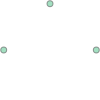

In [2]:
multipoint = shapely.MultiPoint([(1,1), (3,3), (5,1)])
multipoint

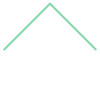

In [3]:
linestring = shapely.LineString(multipoint.geoms)
linestring

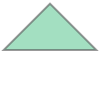

In [4]:
polygon = shapely.Polygon(multipoint.geoms)
polygon

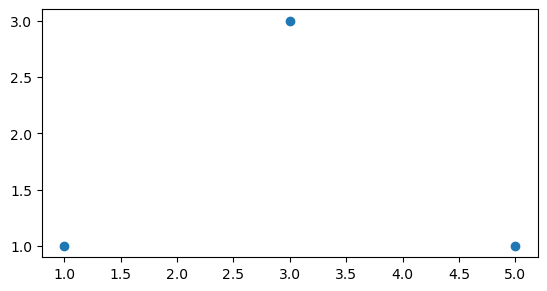

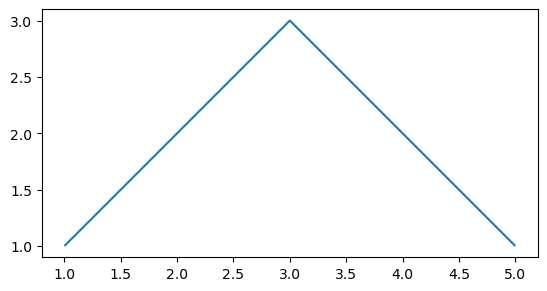

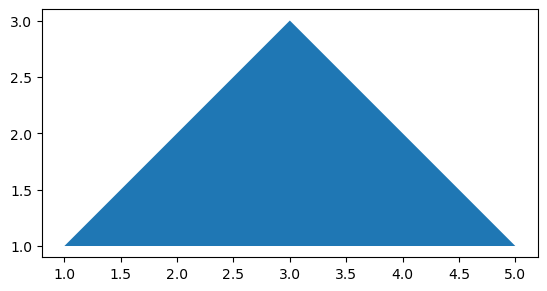

In [5]:
gpd.GeoSeries(multipoint).plot(); 
gpd.GeoSeries(linestring).plot(); 
gpd.GeoSeries(polygon).plot();

>Can convert back

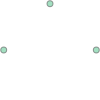

In [6]:
shapely.MultiPoint(linestring.coords)

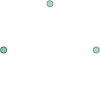

In [7]:
shapely.MultiPoint(polygon.exterior.coords)

>Constructing and deconstructing multi-geometries

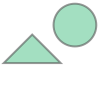

In [8]:
multipolygon = shapely.MultiPolygon([
    polygon, 
    shapely.affinity.translate(polygon.centroid.buffer(1.5), 3, 2)
])
multipolygon

In [10]:
multipolygon.geoms[0], multipolygon.geoms[1]

(<POLYGON ((1 1, 3 3, 5 1, 1 1))>,
 <POLYGON ((7.5 3.667, 7.493 3.52, 7.471 3.374, 7.435 3.231, 7.386 3.093, 7.3...>)

# Type casting with geopandas

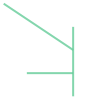

In [11]:
l1 = shapely.LineString([(1, 5), (4, 3)])
l2 = shapely.LineString([(4, 4), (4, 1)])
l3 = shapely.LineString([(2, 2), (4, 2)])
ml = shapely.MultiLineString([l1, l2, l3])
ml

>Multi-part to single-part

In [12]:
geom = gpd.GeoSeries(ml)
geom

0    MULTILINESTRING ((1 5, 4 3), (4 4, 4 1), (2 2,...
dtype: geometry

In [39]:
dat = gpd.GeoDataFrame(geometry=geom, data=pd.DataFrame({'id': [1]}))
dat

,id,geometry
0,1,"MULTILINESTRING ((1 5, 4 3), (4 4, 4 1), (2 2,..."


In [40]:
list(ml.geoms)

[<LINESTRING (1 5, 4 3)>, <LINESTRING (4 4, 4 1)>, <LINESTRING (2 2, 4 2)>]

In [41]:
dat1 = dat.explode(index_parts=True).reset_index() 
dat1

,level_0,level_1,id,geometry
0,0,0,1,"LINESTRING (1 5, 4 3)"
1,0,1,1,"LINESTRING (4 4, 4 1)"
2,0,2,1,"LINESTRING (2 2, 4 2)"


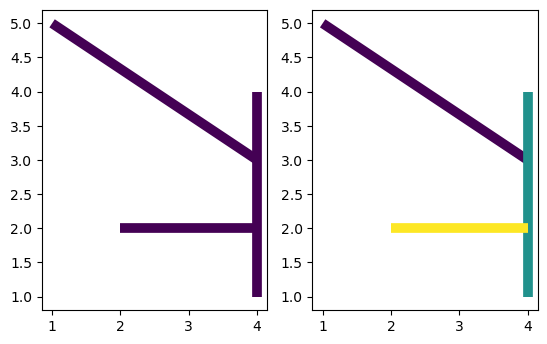

In [47]:
fig, (ax1, ax2) = plt.subplots(1,2)
dat.plot(ax=ax1, column='id', lw=7)
dat1.plot(ax=ax2, column='level_1', lw=7);

>LineString to Multipoint in geopandas

In [48]:
dat2 = dat1.copy() 
dat2.geometry = dat2.geometry.apply(
    lambda x: shapely.MultiPoint(x.coords)
)
dat2

,level_0,level_1,id,geometry
0,0,0,1,"MULTIPOINT ((1 5), (4 3))"
1,0,1,1,"MULTIPOINT ((4 4), (4 1))"
2,0,2,1,"MULTIPOINT ((2 2), (4 2))"


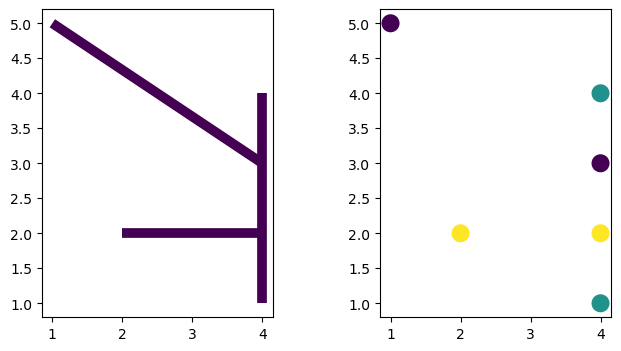

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))
dat.plot(ax=ax1, column='id', lw=7)
dat2.plot(ax=ax2, column='level_1', lw=7);

>Single-part to multi-part with `dissolve`

In [50]:
dat1.dissolve(by='id').reset_index()

,id,geometry,level_0,level_1
0,1,"MULTILINESTRING ((1 5, 4 3), (4 4, 4 3), (4 3,...",0,0


>Dissolve the 16 nz polygons into north and south groups

In [52]:
nz_dis1 = (nz[['Island', 'Population', 'geometry']]
              .dissolve(by='Island', aggfunc='sum')
              .reset_index())
nz_dis1

,Island,geometry,Population
0,North,"MULTIPOLYGON (((1865558.829 5462204.443, 18612...",3671600.0
1,South,"MULTIPOLYGON (((1229729.735 4798718.607, 12299...",1115600.0


>Seperate the 16 nz polygons into north and south groups without dissolving internal borders

In [54]:
nz_dis2 = (
    nz.groupby('Island')
      .agg({
          'Population': 'sum', 
          'geometry': lambda x: shapely.MultiPolygon(
                                          x.explode().to_list()
                                        )
      }).reset_index()
)
nz_dis2 = (gpd.GeoDataFrame(nz_dis2)
             .set_geometry('geometry')
             .set_crs(nz.crs)) 
nz_dis2

,Island,Population,geometry
0,North,3671600.0,"MULTIPOLYGON (((1745493.196 6001802.169, 17405..."
1,South,1115600.0,"MULTIPOLYGON (((1557042.169 5319333.386, 15542..."


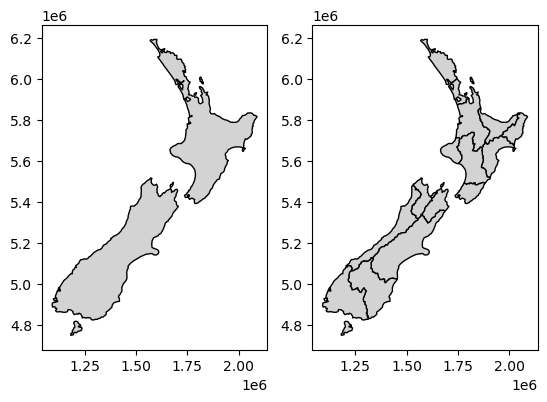

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2)
nz_dis1.plot(ax=ax1, color='lightgrey', ec='k')
nz_dis2.plot(ax=ax2, color='lightgrey', ec='k');